# Homework 5 - The eternal significance of publications and citations!

#### Group 15 <br>

<div style="float: left;">
    <table>
        <tr>
            <th>Student</th>
            <th>GitHub</th>
            <th>Matricola</th>
            <th>E-Mail</th>
        </tr>
        <tr>
            <td>André Leibrant</td>
            <td>JesterProphet</td>
            <td>2085698</td>
            <td>andre.leibrant@gmx.de</td>
        </tr>
        <tr>
            <td>Gianluca Procopio</td>
            <td>gianluca-24</td>
            <td>1942103</td>
            <td>procopio.1942103@studenti.uniroma1.it</td>
        </tr>
        <tr>
            <td>Susanna Bravi</td>
            <td>susannabravi</td>
            <td>1916681</td>
            <td>bravi.1916681@studenti.uniroma1.it</td>
        </tr>
    </table>
</div>

#### Import Libraries and Modules

In [1]:
import ast
import csv
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as plt
import time
import itertools
import random
import heapq
from collections import deque

## 1. Data
In this homework, you will work on a dataset that contains information about a group of papers and their citation relationships. You can find and download the dataset [here](https://www.kaggle.com/datasets/mathurinache/citation-network-dataset).

### Graphs setup
Based on the available data, you will create two graphs to model our relationships as follows:

1. **Citation graph:** This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2. **Collaboration graph:** This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing
The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

As a result, you will attempt to approximate that most connected component by performing the following steps:

1. Identify the top **10,000 papers** with the <u>highest number of citations</u>.


2. Then the **nodes** of your graphs would be as follows:

    **Citation graph:** you can consider each of the papers as your nodes

    **Collaboration graph:** the authors of these papers would be your nodes


3. For the **edges** of the two graphs, you would have the following cases:

    **Citation graph:** only consider the citation relationship between these 10,000 papers and ignore the rest.

    **Collaboration graph:** only consider the collaborations between the authors of these 10,000 papers and ignore the rest.
    
---

We decided to read the large JSON file line by line and save the paper `id` with corresponding `n_citation` in a list.

---

In [ ]:
# File path for papers json file
file_path = "data.json"

# List to store paper information
papers = []

# Open the papers json file
with open(file_path, "r") as file:
    
    # Iterate through every line of the file
    for line_number, line in enumerate(file):
        
        # Remove the leading comma
        if line.startswith(","):
            line = line[1:]
        
        # Skip the opening and ending braket
        if len(line) > 2:
            
            # Skip lines that have non-readable characters
            try:
            
                # Parse the json line
                data = json.loads(line)

                # Extract the id and number of citations (set to 0 if doesn't exist)
                paper_id = data["id"]
                paper_citations = data.get("n_citation", 0)

                # Append the information to the list
                papers.append({"id": paper_id, "n_citations": paper_citations})
                
            except:
                pass

---

In the next step we sort the list by `n_citations`, extract the top 10,000 entries and convert the id key values to a list.

---

In [ ]:
# Sort the list based on the number of citations
papers.sort(key=lambda paper: paper["n_citations"], reverse=True)

# Extract the top 10000 entries
top_10000_papers = papers[:10000]

# Convert id key values to list
paper_ids = [paper["id"] for paper in top_10000_papers]

---

Finally, we are going to iterate through the JSON file again and only extract the papers which are inside the top 10,000 list.

---

In [7]:
# Initialize an empty Pandas DataFrame
df_top_10000_papers = pd.DataFrame()

# Open the papers json file
with open(file_path, "r") as file:
    
    # Iterate through every line of the file
    for _, line in enumerate(file):
        
        # Remove the leading comma
        if line.startswith(","):
            line = line[1:]
        
        # Skip the opening and ending braket
        if len(line) > 2:
            
            # Skip lines that have non-readable characters
            try:
            
                # Parse the json line
                data = json.loads(line)

                # Only append if the id is from the top 10000 papers list
                if data["id"] in paper_ids:

                    # Load the json string into a temporary Pandas DataFrame
                    tmp_df = pd.read_json(line, lines=True)

                    # Append the temporary DataFrame to the main DataFrame
                    df_top_10000_papers = pd.concat([df_top_10000_papers, tmp_df], ignore_index=True)
            
            except:
                pass

---

We save the final result inside a CSV file, so that we don't have to always rerun the previous steps.

---

In [9]:
# Save results in CSV file
df_top_10000_papers.to_csv("top_10000_papers.csv", index=False)

---

We read the results inside the CSV file into a Pandas DataFrame for creating the citation and collaboration graphs.

---

In [2]:
# Read results from CSV file
df_top_10000_papers = pd.read_csv("top_10000_papers.csv")

---

First, we are going to create the citation (direct) graph using the paper's citation relationships. For this we extract all unique values between paper `ids` and `references` (which we convert from a string to a list of integers) and save the results inside `all_nodes`. Then we iterate through every paper, add the node if it is inside `all_nodes`, and add the edge between the `id` and `reference` if both are inside `all_nodes`.

---

In [3]:
# Drop all entries where the references field is empty
df_top_10000_papers = df_top_10000_papers.dropna(subset=["references"])

# Create an empty directed graph for the citations
citation_graph = nx.DiGraph()

# Get all unique paper ids
unique_ids = df_top_10000_papers["id"].unique()

# Extract all references and convert to a list of integers
reference_values = []
for references_str in df_top_10000_papers["references"]:
    references_list = ast.literal_eval(references_str)
    reference_values.extend(references_list)

# Get all unique values between both columns
all_nodes = set(unique_ids).union(set(reference_values))

# Add nodes and edges to the graph only for the nodes present in the file
for _, row in df_top_10000_papers.iterrows():
    paper_id = row["id"]
    references = ast.literal_eval(row["references"])
    
    # Add node if not already added
    if paper_id not in citation_graph.nodes:
        citation_graph.add_node(paper_id)
    
    # Add edges for references that are in the file
    for ref_id in references:
        if ref_id in all_nodes:
            citation_graph.add_edge(paper_id, ref_id)

---

In the next step we find the largest strongly connected component and save the result inside a subgraph.

---

In [4]:
# Get all strongly connected components
strongly_connected_components = nx.strongly_connected_components(citation_graph)

# Find the largest strongly connected component
largest_component = max(strongly_connected_components, key=len)

# Create a subgraph from the largest component
citation_subgraph = citation_graph.subgraph(largest_component)

---

We quickly plot the subgraph:

---

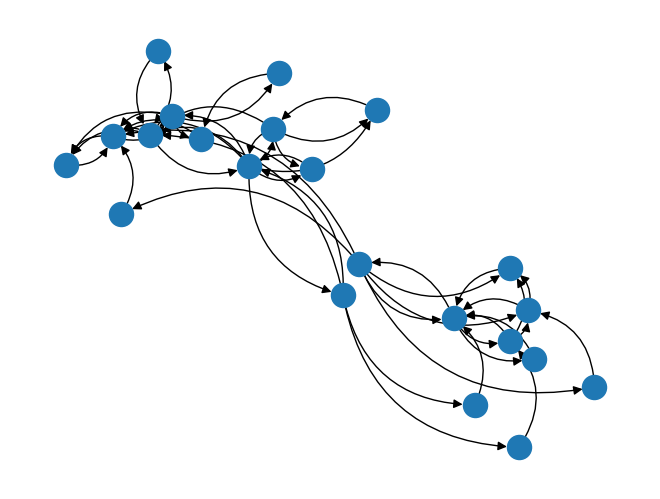

In [5]:
# Plot the subgraph
pos = nx.spring_layout(citation_subgraph)
nx.draw(citation_subgraph,
        pos,
        with_labels=False,
        arrowsize=13,
        connectionstyle="arc3, rad=0.4")

---

Next, we are going to create the collaboration (undirected and weigthed) graph using the collaborations of the paper's authors. For this we iterate through every paper and convert the authors list from a string to a list of dictionaries. Then we iterate through every pair of authors and add the nodes and edges if they don't exist yet. For the edge weight we decided to use the number of times two authors have collaborated. We are going to count the number of collaborations between each pair of authors and use that count as the weight.

---

In [6]:
# Create an empty undirected graph for the collaboration
collaboration_graph = nx.Graph()

# Iterate through each row in the DataFrame
for _, paper in df_top_10000_papers.iterrows():
    
    # Convert the string to a list of dictionaries
    authors_list = ast.literal_eval(paper["authors"])

    # Iterate through every pair of authors
    for i, author_i_dict in enumerate(authors_list):
        for j, author_j_dict in enumerate(authors_list[i+1:], start=i+1):
            
            # Retrieve author names
            author_i = author_i_dict["name"]
            author_j = author_j_dict["name"]
            
            # Initialize weight to 1
            weight = 1
            
            # Add nodes
            collaboration_graph.add_nodes_from([author_i, author_j])
            
            # Add edge if not already added and if yes, increase the weight by 1
            if not collaboration_graph.has_edge(author_i, author_j):
                collaboration_graph.add_edge(author_i, author_j, weight=weight)
                collaboration_graph[author_i][author_j]["titles"] = [paper["title"]]
            else:
                collaboration_graph[author_i][author_j]["weight"] += 1
                collaboration_graph[author_i][author_j]["titles"] += [paper["title"]]

In [7]:
# Get all connected components
connected_components = list(nx.connected_components(collaboration_graph))

# Find the largest connected component
largest_component = max(connected_components, key=len)

# Create a subgraph from the largest connected component
collaboration_subgraph = collaboration_graph.subgraph(largest_component)

---

**Note:** A graphical representation was not possible because the subgraph has 7324 nodes with 72875 edges!

---

# 2. Controlling system

## 2.1. Backend Implementation

---
### Functionality 1 - Graph Feature
---

to comment

In [8]:
# functionality 1
def graph_features(graph,graph_name):
  nodes_n = graph.number_of_nodes()
  edge_n = graph.number_of_edges()
  density = nx.density(graph)
  degree_dist = nx.degree_histogram(graph)
  tot_degree = dict(graph.degree())
  degree_avg = sum(tot_degree.values()) / nodes_n

  # compute hub, 95th percentile
  perc = np.percentile(list(tot_degree.values()),95)
  hub = [node_key for node_key, node_val in tot_degree.items() if node_val >= perc]
  # graph dense or sparse
  # max number of edges
  th = 0.6
  max_edges = nodes_n * (nodes_n - 1)/2
  is_dense = True if edge_n / max_edges >= th else False
  return nodes_n,edge_n,density,degree_dist,degree_avg,hub,is_dense

name = int(input('Insert 0 for Citation Graph and 1 for Collaboration Graph: '))

if name == 0:
  cit_features = graph_features(citation_graph,'citation')
  print(cit_features)
else:
  collab_features = graph_features(collaboration_graph,'collaboration')
  print(collab_features)

(99914, 187027, 1.8735097701423364e-05, [0, 66741, 13919, 5271, 2507, 1457, 889, 614, 495, 421, 396, 351, 334, 347, 289, 273, 298, 270, 253, 249, 240, 243, 221, 224, 209, 198, 169, 206, 176, 152, 153, 136, 128, 116, 111, 129, 103, 77, 104, 60, 75, 69, 41, 44, 69, 37, 34, 44, 51, 37, 47, 33, 39, 21, 30, 31, 20, 26, 23, 22, 16, 19, 23, 16, 18, 11, 9, 12, 14, 9, 17, 9, 8, 10, 7, 13, 15, 4, 8, 12, 9, 10, 5, 9, 7, 6, 3, 8, 11, 5, 9, 7, 6, 7, 10, 6, 3, 3, 6, 4, 4, 1, 4, 4, 7, 4, 5, 4, 1, 3, 1, 5, 1, 2, 0, 3, 5, 5, 1, 3, 5, 3, 1, 1, 4, 3, 3, 2, 2, 2, 4, 2, 1, 1, 2, 3, 4, 2, 3, 0, 1, 0, 0, 5, 2, 0, 2, 3, 1, 1, 2, 1, 2, 0, 0, 2, 3, 2, 1, 0, 1, 2, 3, 0, 2, 1, 0, 2, 2, 3, 1, 2, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 1, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 3, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [9]:
name = int(input('Insert 0 for Citation Graph and 1 for Collaboration Graph: '))

if name == 0:
  nodes_n,edge_n,density,degree_dist,degree_avg,hub,is_dense = graph_features(citation_graph,'citation')
else:
  collab_features = graph_features(collaboration_graph,'collaboration')

### Functionality 2 - Nodes' contribution

To comment

In [10]:
def nodes_contribution(graph,node,graph_name):
  btwn = nx.betweenness_centrality_subset(graph,[node],graph.nodes())
  pr = nx.pagerank(graph,personalization={node: 1.0})
  clsn = nx.closeness_centrality(graph,u=node)
  dc = nx.degree_centrality(graph)[node]
  return btwn,pr,clsn,dc
node_test = 2238402354
if int(input('Insert 0 for Citation Graph and 1 for Collaboration Graph: ')) == 0:
  cit_contribution = nodes_contribution(citation_graph,node_test,'citation')
else:
  collab_contribution = nodes_contribution(collaboration_graph,'collaboration')

### Functionality 3 - Shortest ordered walk

In [11]:
def bfs_shortest_walk(graph, start, end):
    
    # Initialize a queue with the start node
    queue = [(start, [start], [])]
    
    # Initialize an empty set to keep track of visited nodes
    visited = set()

    # Loop through until the end node is reached
    while queue:
        
        # Dequeue the current node to analyse and the current path from the queue
        current_node, path, papers = queue.pop(0)
        
        # Check if the current node is the end node
        if current_node == end:
            return path, papers
        
        # Mark the current node as visited
        visited.add(current_node)

        # Iterate through all neighbour nodes
        for neighbor in set(graph.neighbors(current_node)) - visited:
            
            # Retrieve the paper titles the authors wrote together
            titles = graph[current_node][neighbor]["titles"]
            
            # Enqueue the neighbor node and update the path
            queue.append((neighbor, path + [neighbor], papers + [titles[0]]))

    # Return None if no path was found
    return None, None

In [12]:
def shortest_ordered_walk(graph, subsample):
    
    path = []
    papers = []

    for i in range(0, len(subsample)-1):
        
        if subsample[i] not in graph.nodes():
            print("WARNING: This subsequence of nodes is not in the graph! \
                  Try to change N or check if the spelling is correct!")
            return
        
        shortes_walk, titles = bfs_shortest_walk(graph, subsample[i], subsample[i+1])
            
        if shortes_walk is None:
            print("WARNING: There is no such path!")
            return None, None
        else:
            if path == []:
                path = shortes_walk
                papers = titles
            else:
                path += shortes_walk[1:]
                papers += titles

    return path, papers

In [13]:
# We choose an arbitrary N which has to be lower than the total number of nodes
N = 1000

degrees = dict(collaboration_graph.degree())
topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
topN_authors_aux = [el[0] for el in topN_authors]
graph_auth = collaboration_graph.subgraph(topN_authors_aux)

n = 7
random.seed(40)

subsample = random.sample(topN_authors_aux, n)

print("Subsample:")
for author in subsample:
    print(author)

path, papers = shortest_ordered_walk(graph_auth, subsample)

print('\nList of papers we crossed:')
for paper in papers:
    print(paper)

print('\nPath we found:')
for node in path:
    print(node)

Subsample:
Conor McMenamin
Sandra E. Orchard
Chris P Ponting
Tripti Gupta
Morana Vitezic
Jun Kawai
Ioannis Xenarios

List of papers we crossed:
InterPro in 2011: new developments in the family and domain prediction database
IntAct—open source resource for molecular interaction data
IntAct—open source resource for molecular interaction data
The InterPro Database, 2003 brings increased coverage and new features
The InterPro Database, 2003 brings increased coverage and new features
InterPro: the integrative protein signature database
Reference sequence (RefSeq) database at NCBI: current status, taxonomic expansion, and functional annotation
Reference sequence (RefSeq) database at NCBI: current status, taxonomic expansion, and functional annotation
InterPro: the integrative protein signature database
A promoter-level mammalian expression atlas
A promoter-level mammalian expression atlas
A promoter-level mammalian expression atlas
The InterPro protein families database: the classification r

---
#### Chatgpt implementation
---

In [24]:
import queue

def bfs_shortest_walk(graph, start, end):
    visited = set()
    q = queue.Queue()
    q.put((start, [start]))

    while not q.empty():
        current, path = q.get()

        if current == end:
            # Found the destination
            return path, get_papers_along_path(graph, path)

        visited.add(current)

        for neighbor in graph.neighbors(current):
            if neighbor not in visited and neighbor == path[len(path) - 1]:
                # Preserve order
                q.put((neighbor, path + [neighbor]))

    return None, None

def shortest_ordered_walk_chatGPT(graph, subsample):
    path = []
    papers = []

    for i in range(len(subsample) - 1):
        current_author = subsample[i]
        next_author = subsample[i + 1]

        if current_author not in graph.nodes():
            print("WARNING: This subsequence of nodes is not in the graph! \
                  Try to change N or check if the spelling is correct!")
            return

        shortest_walk, titles = bfs_shortest_walk(graph, current_author, next_author)

        if shortest_walk is None:
            print("WARNING: There is no such path!")
            return None, None

        if path == []:
            path = shortest_walk
            papers = titles
        else:
            # Skip the first node to avoid duplicates
            path += shortest_walk[1:]
            papers += titles

    return path, papers

def get_papers_along_path(graph, path):
    papers = []
    for i in range(len(path) - 1):
        papers.extend(graph[path[i]][path[i + 1]]['titles'])
    return papers

In [26]:
N = 1000

degrees = dict(collaboration_graph.degree())
topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
topN_authors_aux = [el[0] for el in topN_authors]
graph_auth = collaboration_graph.subgraph(topN_authors_aux)

n = 7
random.seed(40)

subsample = random.sample(topN_authors_aux, n)

print("Subsample:")
for author in subsample:
    print(author)

path, papers = shortest_ordered_walk_chatGPT(graph_auth, subsample)

print('\nList of papers we crossed:')
for paper in papers:
    print(paper)

print('\nPath we found:')
for node in path:
    print(node)

Subsample:
Conor McMenamin
Sandra E. Orchard
Chris P Ponting
Tripti Gupta
Morana Vitezic
Jun Kawai
Ioannis Xenarios

Path we found:


TypeError: 'NoneType' object is not iterable

ChatGPT implementation is not working...   
We wrote a detailed prompt reporting the input, the desidered output and your indications. In the first place it didn't understand well the problem, therefore we showed it our implementation of the code and we asked for another solution more efficient but it couldn't give us any.            
We set a seed and used the same input in order to have a comparison between the 2 implementations.              
Its implementation is of course similar to ours but the bfs is implemented through a Queue, this can be a reasonable way to implement the BFS but in this case it doesn't work and so it doesn't find the shortest path.


### Functionality 4 - Disconnecting Graphs

In [ ]:
def bfs(graph, start, end):
    visited = set()
    queue = deque([(start, [])])

    while queue:
        current, path = queue.popleft()
        if current not in visited:
            visited.add(current)
            path = path + [current]

            if current == end:
                return path

            for neighbor in graph[current]:
                if neighbor not in visited:
                    queue.append((neighbor, path))

    return None

In [ ]:
from collections import defaultdict, deque

def min_cut_edges(graph, node_a, node_b):
    removed_edges = 0
    total_weight = 0

    while True:
        path = bfs(graph, node_a, node_b)
        if not path:
            print("The nodes are disconnected")
            break  # No path found between A and B, break the loop

        # Cut the graph along the found path
        for i in range(len(path) - 1):
            node1, node2 = path[i], path[i+1]

            # Remove the edge between node1 and node2
            if graph.has_edge(node1, node2):
                # Get the weight of the removed edge
                edge_data = graph.get_edge_data(node1, node2)
                if edge_data is not None and "weight" in edge_data:
                    total_weight += edge_data["weight"]

                graph.remove_edge(node1, node2)
                removed_edges += 1

    return total_weight, removed_edges

In [ ]:
N = 1000
degrees = dict(collaboration_subgraph.degree())
topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
topN_authors_aux = [el[0] for el in topN_authors]
subgraph_auth = collaboration_subgraph.subgraph(topN_authors_aux)
n = 2
subsample = random.sample(topN_authors_aux, n)
cnt = min_cut_edges(collaboration_graph,subsample[0],subsample[1])
print(cnt)

The nodes are disconnected
(514, 395)


---
### Functionality 5 - Extracting Communities
---

In [ ]:
def extracting_communities(graph, p1, p2):
    # We need an undirected graph
    graph_copy = graph.to_undirected()

    if nx.number_connected_components(graph_copy) > 1:
        print("The graph is not connected")
        return 0,[],False
    
    # Calculate the initial number of edges
    num_edges_start = graph_copy.number_of_edges()

    # Calculate betweenness centrality for each edge
    edge_betweenness = nx.edge_betweenness_centrality(graph_copy)

    # Sort edges by betweenness centrality in descending order
    sorted_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)
    
   
    # Remove edges until the graph has more than one connected component
    while nx.number_connected_components(graph_copy) == 1:
        edge_to_remove = sorted_edges.pop(0)[0]
        graph_copy.remove_edge(*edge_to_remove)

    # Find connected components as communities
    communities = list(nx.connected_components(graph_copy))

    # Check if Paper_1 and Paper_2 belong to the same community
    same_community = any({p1, p2} <= community for community in communities)

    # Calculate the minimum number of edges removed
    num_edges_end = graph_copy.number_of_edges()
    return num_edges_start-num_edges_end, communities, same_community


In [ ]:
N = 1000
degrees = dict(citation_subgraph.degree())
topN_papers = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
print("Number of nodes:",len(topN_papers))
topN_papers_aux = [el[0] for el in topN_papers]
subgraph_ppr2 = collaboration_subgraph.subgraph(topN_papers_aux)
#nx.draw(subgraph_ppr2)
n = 2
subsample = random.sample(topN_papers_aux, n)
print("Papers we want:",subsample[0],subsample[1])
min,cm,is_cm = extracting_communities(citation_graph.copy(),subsample[0],subsample[1])
print("Edges to eliminate:",min)
print("Number of communities:",len(cm))
print("Are the paper in the same community?",is_cm)
#nx.draw(copy)

Number of nodes: 22
Papers we want: 2092654472 2152761983


The graph is not connected
Edges to eliminate: 0
Number of communities: 0
Are the paper in the same community? False


---

In the next step we find the largest connected component and save the result inside a subgraph.

---

## 4. Command Line Question (CLQ)
In this question, you should use any command line tools that you know to answer the following questions using the **directed** and **unweighted graph** that you have previously created: **Citation graph**:

---

Before solving the questions in the Command Line we find the largest strongly connected component and save the subgraph inside a file which we are going to use in the Command Line. We decided to work on a subgraph for computation time reasons.

In [ ]:
# Get all strongly connected components
strongly_connected_components = nx.strongly_connected_components(citation_graph)

# Find the largest strongly connected component
largest_component = max(strongly_connected_components, key=len)

# Create a subgraph from the largest component
citation_subgraph = citation_graph.subgraph(largest_component)

---

We quickly plot the subgraph:

---

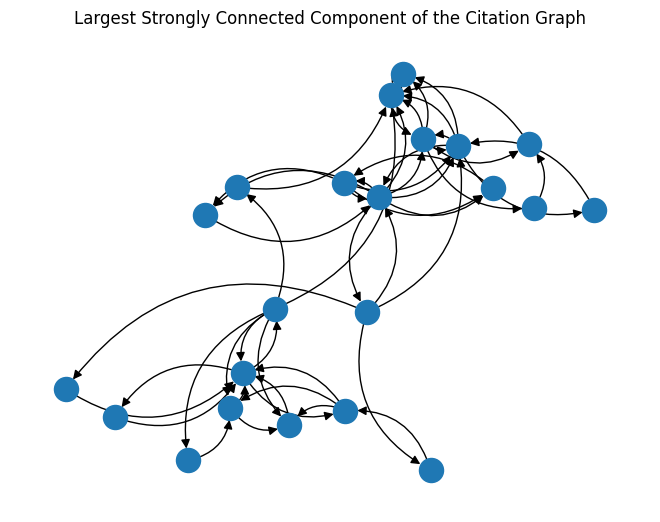

In [ ]:
# Plot the subgraph
pos = nx.spring_layout(citation_subgraph)
nx.draw(citation_subgraph,
        pos,
        with_labels=False,
        arrowsize=13,
        connectionstyle="arc3, rad=0.4")
plt.title("Largest Strongly Connected Component of the Citation Graph")
plt.show()

---

At last we save the subgraph in a file.

---

In [ ]:
nx.write_edgelist(citation_subgraph, "citation_subgraph.edgelist", data=False)

---

The shell script is saved in the file `CommandLine.sh`. First you need to navigate to the file where the `scitation_subgraph.edgelist` file is saved by using the `cd` command and then you can run the script with the `./CommandLine.sh` command (before that you have to make sure that it is executable by using the `chmod +x CommandLine.sh` command).

---

---

1. Is there any node that acts as an important "connector" between the different parts of the graph?

To identify a possible important connector we are going to calculate the betweenness centrality for each note:

```bash
# Calculate betweenness centrality for each node
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); print('\n'.join([f'{node} {centrality}' for node, centrality in nx.betweenness_centrality(citation_subgraph).items()]))" > betweenness_centrality.txt

# Sort nodes by betweenness centrality in descending order
sort -k2 -rn betweenness_centrality.txt > sorted_betweenness_centrality.txt

# Print the top connectors
head -n 10 sorted_betweenness_centrality.txt
```

![Screenshot1](Screenshot1.png)

---

**Conclusion:** The node with the paper id `2121127625` has a betweenness centrality score of 0.51 which indicates that, on average, half of the shortest paths in the graph pass through that specific node. The nodes with the paper ids `2032210760`, `2107890099`, and `1975846642` have a similar importance.

---

2. How does the degree of citation vary among the graph nodes?

Because not specified we are going to analyze the in-degrees and out-degrees of each node. In our context the in-degrees represent the number of times a paper has been cited and the out-degrees represent the number of citations made by that paper.

```bash
# Calculate in-degree and out-degree for each node and print the largest and smallest value for each type of degree
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); in_degrees = sorted(citation_subgraph.in_degree(), key=lambda x: x[1], reverse=True); out_degrees = sorted(citation_subgraph.out_degree(), key=lambda x: x[1], reverse=True); print(f'Largest In-Degree: {in_degrees[0][0]} {in_degrees[0][1]}'); print(f'Lowest In-Degree: {in_degrees[-1][0]} {in_degrees[-1][1]}'); print(f'Largest Out-Degree: {out_degrees[0][0]} {out_degrees[0][1]}'); print(f'Lowest Out-Degree: {out_degrees[-1][0]} {out_degrees[-1][1]}')"
```

![Screenshot2](Screenshot2.png)

---

**Conclusion:** Both type of degrees vary between 1 and 7.

---

3. What is the average length of the shortest path among nodes?

For this we can straight forward use the inbuild function `average_shortest_path_length` from `networkx`.

```bash
# Calculate average length of the shortest path among nodes
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); average_shortest_path = nx.average_shortest_path_length(citation_subgraph); print(f'Average Shortest Path Length: {average_shortest_path}')"
```

![Screenshot3](Screenshot3.png)

---

**Conclusion:** The average length of the shortest path is 4.24 nodes.

---